In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np

import osu.dataset as dataset
import torch

osu! path: None/../Local/osu!


In [2]:
# reload from saved

# mrekk glob
xs = np.load(f'.datasets/xs_2225_12ms.npy')
ys = np.load(f'.datasets/ys_2225_12ms.npy')


In [11]:
import torch
import gc

BATCH_SIZE = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Clear GPU cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

2569

In [17]:
from os import terminal_size
from typing import Optional
from dataclasses import dataclass

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.attention import SDPBackend, sdpa_kernel

import osu.dataset as dataset
from models.annealer import Annealer
from models.base import OsuModel

import torch
import torch.nn as nn
from torch.nn.attention import SDPBackend, sdpa_kernel


@dataclass
class TCNParams:
    """Parameters for configuring a Temporal Convolutional Network"""
    layers: tuple = (64, 128, 196, 128, 64)
    lookahead_layers: int = 0
    lookahead_mode: str = "full"  # "full" or "centered"


# a causal convolutional layer that preserves the length of the original sequence
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, start_offset=0, **kwargs):
        """
        start_offset is the time index where the kernel starts at. By default it will start
        at time index 0, and since CausalConv1d's sliding kernel is left aligned, it will use padding
        on the left. If start_offset > 0, then padding will be added appropriately on the right side, and
        subtracted from the left, as any start_offset value preserves the original output shape of the layer. 
        Think of it as a way to add a small lookahead window. 

        start_offset must be strictly < kernel_size
        
        [a b c d e f g h]
        -> pad (lookahead = 0, k = 3) ->
        [0 0 a]b c d e f g h
         0[0 a b]c d e f g h
         0 0[a b c]d e f g h

        or pad (lookahead = 2, k = 3) ->
        [a b c]d e f g h 0 0
         a[b c d]e f g h 0 0
         a b[c d e] f g h 0 0
        """
        super().__init__()
        p = (kernel_size - 1) * dilation
        self.lpad = max(p - start_offset, 0)
        self.rpad = start_offset
        self.dilation = dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              dilation=dilation, **kwargs)

    def forward(self, x):
        x = F.pad(x, (self.lpad, self.rpad))
        return self.conv(x)


class CausalTCN(nn.Module):
    def __init__(self, in_channels, out_channels, layers, lookahead_layers=0, lookahead_mode="full"):
        """
        layers is a tuple of (n1, n2, n3...)
        where each n is a number of channels, and constructs layers:
        (in_channels, n1)
        (n1, n2)
        (n2, n3)
        ...
        (ni, out_channels)

        when these layers are applied, their dilation increases by a factor of two. 
        
        the amount of timesteps of future context the model has acces to is determined by
        2 ^ lookahead_layers               if lookahead_mode = full 
        max(2 ^ (lookahead_layers - 1), 1) if lookahead_mode = centered 

        full lookahead mode effectively maps a seq to a seq of the same length, 
        where each element in the new seq has context about the future timesteps.

        centered lookahead mode maps a seq to a seq of the same length, 
        where each element in the new seq has context about both the past and the future. 

        lookahead_layers must be < len(layers).
        
        after the amount of requested lookahead layers have been applied, the dilation will reset to 1, and then
        increase accordingly for the following causal layers. 
        """
        super().__init__()

        self.input = in_channels
        self.output = out_channels

        self.conv_layers = []

        channels = [in_channels, *layers, out_channels]
        
        for i in range(len(channels) - 1):
            in_c = channels[i]
            out_c = channels[i+1]
            if i < lookahead_layers:
                self.conv_layers.append(
                    CausalConv1d(in_c, out_c, kernel_size=3, dilation=2 ** i, start_offset=(2 if lookahead_mode == "full" else 1))
                )
            else:
                self.conv_layers.append(
                    CausalConv1d(in_c, out_c, kernel_size=3, dilation=2 ** (i - lookahead_layers))
                )
                
        self.conv_layers = nn.ModuleList(self.conv_layers)

        self.relu = nn.ReLU()
        
    def forward(self, sequence):
        """
        sequence is of shape (B, T, F) where 
        B = batch size
        T = sequence length
        F = feature count
        """
        batch_size, seq_len, _ = sequence.shape

        map = sequence.transpose(1, 2)  # (B, F, T)

        out = map

        for layer in self.conv_layers:
            out = layer(out)

            if layer != self.conv_layers[-1]:
                out = self.relu(out)
                
        return out.transpose(1, 2)  # transpose back to (B, T, F')


class ReplayGenerator(nn.Module):
    def __init__(
        self,
        noise_dim=32,
        tcn_params: TCNParams = None,
    ):
        super().__init__()
        
        if tcn_params is None:
            tcn_params = TCNParams()
        
        self.noise_dim = noise_dim
        
        # TCN input includes both map features and noise
        self.tcn = CausalTCN(
            len(dataset.INPUT_FEATURES) + noise_dim, 
            2, 
            layers=tcn_params.layers, 
            lookahead_layers=tcn_params.lookahead_layers, 
            lookahead_mode=tcn_params.lookahead_mode
        )

    def forward(self, map_features, noise):
        # map_features: (B, T, F)
        # noise: (B, noise_dim)
        
        B, T, F = map_features.shape
        
        # Broadcast noise across time dimension: (B, noise_dim) -> (B, T, noise_dim)
        noise_expanded = noise.unsqueeze(1).expand(B, T, self.noise_dim)
        
        # Concatenate map features with noise
        x = torch.cat([map_features, noise_expanded], dim=-1)  # (B, T, F + noise_dim)
        
        return self.tcn(x)


class ReplayCritic(nn.Module):
    def __init__(
        self, 
        input_size,
        tcn_params: TCNParams = None,
    ):
        super().__init__()
        
        if tcn_params is None:
            tcn_params = TCNParams()
        
        # TCN processes map_features + positions concatenated
        self.tcn = CausalTCN(
            input_size + 2,  # input features + 2D positions
            1,  # output a single score per timestep
            layers=tcn_params.layers,
            lookahead_layers=tcn_params.lookahead_layers,
            lookahead_mode=tcn_params.lookahead_mode
        )

    def forward(self, map_features, positions):
        # map_features: (B, T, feat_dim), positions: (B, T, 2)
        x = torch.cat([map_features, positions], dim=-1)  # (B, T, feat_dim+2)
        
        # Pass through TCN to get per-timestep scores
        scores = self.tcn(x)  # (B, T, 1)
        
        # Pool over time to get a single score per sequence
        score = scores.mean(dim=1).squeeze(-1)  # (B,)
        
        return score


def gradient_penalty(critic, windowed, real_pos, fake_pos, device, lambda_gp=10.0):
    B = real_pos.shape[0]
    # alpha (B,1,1) will broadcast across (T,2)
    alpha = torch.rand(B, 1, 1, device=device)

    # interpolation in position space
    # (B, T, 2)
    x = (alpha * real_pos + (1.0 - alpha) * fake_pos).requires_grad_(True)

    # (B,)
    C_x = critic(windowed, x)

    # compute gradients of outputs wrt interpolated positions
    # (this works since the gradient distributes)
    # (B, T, 2)
    grads = torch.autograd.grad(
        outputs=C_x.sum(),
        inputs=x,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # flatten per-sample gradients and compute L2 norm per sample
    # (B,)
    grad_norm = grads.reshape(B, -1).norm(2, dim=1)

    gp = ((grad_norm - 1.0) ** 2).mean() * lambda_gp

    del grads, grad_norm, C_x, x

    return gp


# an implementation of a WGAN with a gp critic
class OsuReplayWGAN(OsuModel):
    def __init__(
        self,
        batch_size=64,
        device=None,
        noise_dim=32,
        critic_steps=3,
        lambda_gp=10.0,
        lambda_pos=1.0,
        lambda_adv_annealer=None,
        gen_tcn_params: TCNParams = None,
        critic_tcn_params: TCNParams = None,
        lr_g=1e-4,
        lr_c=1e-4,
        betas_gan=(0.5, 0.9),
        use_gp=True,
        compile=False,
    ):
        self.noise_dim = noise_dim
        self.critic_steps = critic_steps
        self.lambda_gp = lambda_gp
        self.lr_g = lr_g
        self.lr_c = lr_c
        self.betas_gan = betas_gan
        self.lambda_pos = lambda_pos
        self.use_gp = use_gp
        self.lambda_adv_annealer = lambda_adv_annealer or Annealer(
            total_steps=20, range=(0.0, 1.0), cyclical=False
        )
        
        # Default TCN params if not provided
        self.gen_tcn_params = gen_tcn_params or TCNParams(
            layers=(64, 128, 196, 196, 128, 96, 96, 32),
            lookahead_layers=5,
            lookahead_mode="full"
        )
        
        self.critic_tcn_params = critic_tcn_params or TCNParams(
            layers=(64, 128, 196, 128, 64),
            lookahead_layers=2,
            lookahead_mode="full"
        )

        super().__init__(
            batch_size=batch_size,
            device=device,
            compile=compile,
        )

    def _initialize_models(self, **kwargs):
        self.generator = ReplayGenerator(
            noise_dim=self.noise_dim,
            tcn_params=self.gen_tcn_params,
        )

        # scores a play on realness
        self.critic = ReplayCritic(
            len(dataset.INPUT_FEATURES),
            tcn_params=self.critic_tcn_params,
        )

        if self.use_gp:
            print("using gp")
        else:
            print("not using gp")

    def _initialize_optimizers(self):
        self.opt_G = optim.AdamW(
            self.generator.parameters(), lr=self.lr_g, betas=self.betas_gan
        )
        self.opt_C = optim.AdamW(
            self.critic.parameters(), lr=self.lr_c, betas=self.betas_gan
        )

    def _get_state_dict(self):
        return {
            "critic": self.critic.state_dict(),
            "generator": self.generator.state_dict(),
            "noise_dim": self.noise_dim,
            "gen_tcn_params": self.gen_tcn_params,
            "critic_tcn_params": self.critic_tcn_params,
        }

    def _load_state_dict(self, checkpoint):
        if "generator" in checkpoint:
            self.generator.load_state_dict(checkpoint["generator"])
        else:
            print("No generator weights found, not loading generator")

        if "critic" in checkpoint:
            self.critic.load_state_dict(checkpoint["critic"])
        else:
            print("No critic weights found, not loading critic")

    def _train_epoch(self, epoch, total_epochs, **kwargs):
        epoch_total_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_adv_loss = 0.0
        epoch_G_loss = 0.0
        epoch_C_loss = 0.0
        epoch_wass_dist = 0.0

        device = self.device or torch.device("cpu")

        p_real_mean = 0.0
        p_fake_mean = 0.0
        p_wass = 0.0
        for j, (batch_x, batch_y_pos) in enumerate(self.train_loader):
            status_prefix = f"{j}/{len(self.train_loader)} (λ_adv: {self.lambda_adv_annealer.current():.5f}, r: {p_real_mean:.4f}, f: {p_fake_mean:.4f}, w: {p_wass:.4f}) "
            self._set_custom_train_status(status_prefix)

            p_real_mean = 0.0
            p_fake_mean = 0.0
            p_wass = 0.0

            batch_x = batch_x.to(device)
            batch_y_pos = batch_y_pos.to(device)

            # BATCH SIZE
            B = batch_x.shape[0]

            critic_loss_accum = 0.0

            # train the critic for n steps per epoch
            for i in range(self.critic_steps):
                self._set_custom_train_status(
                    status_prefix + f"Critic: {i}/{self.critic_steps}"
                )

                # sample xi noise for generator
                # (B, noise_dim)
                xi_c = torch.randn(B, self.noise_dim, device=device)

                # (B, T, 2)
                fake_pos = self.generator(batch_x, xi_c).detach()

                # (B,)
                real_score = self.critic(batch_x, batch_y_pos)
                # (B,)
                fake_score = self.critic(batch_x, fake_pos)

                real_mean = real_score.mean().item()
                fake_mean = fake_score.mean().item()
                wass = real_mean - fake_mean

                p_real_mean += real_mean
                p_fake_mean += fake_mean
                p_wass += wass

                epoch_wass_dist += wass

                # lambda term is already multiplied in here
                if self.use_gp:
                    gp = gradient_penalty(
                        self.critic,
                        batch_x,
                        real_pos=batch_y_pos,
                        fake_pos=fake_pos,
                        device=device,
                        lambda_gp=self.lambda_gp,
                    )
                else:
                    gp = 0

                # total wgan-gp critic loss
                loss = -(real_score.mean() - fake_score.mean()) + gp

                self.opt_C.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)
                self.opt_C.step()

                critic_loss_accum += loss.item()

            p_real_mean /= self.critic_steps
            p_fake_mean /= self.critic_steps
            p_wass /= self.critic_steps

            # train the generator now
            self._set_custom_train_status(status_prefix + f"Generator")

            xi = torch.randn(B, self.noise_dim, device=device)
            fake = self.generator(batch_x, xi)

            adv_loss = self.lambda_adv_annealer.current() * (-self.critic(batch_x, fake).mean())
            pos_loss = self.lambda_pos * F.smooth_l1_loss(
                fake, batch_y_pos, reduction="mean"
            )

            gen_loss = adv_loss + pos_loss

            self.opt_G.zero_grad()
            gen_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)
            self.opt_G.step()

            epoch_C_loss += critic_loss_accum / max(1, self.critic_steps)
            epoch_G_loss += gen_loss.item()
            epoch_recon_loss += pos_loss.item()
            epoch_adv_loss += adv_loss.item()

        self.lambda_adv_annealer.step()

        nb = len(self.train_loader)
        return {
            "recon": epoch_recon_loss / nb,
            "adv": epoch_adv_loss / nb,
            "g": epoch_G_loss / nb,
            "c": epoch_C_loss / nb,
            "wass": epoch_wass_dist / (nb * self.critic_steps)
        }

    def generate(self, beatmap_data, **kwargs):
        self._set_eval_mode()

        with torch.no_grad():
            beatmap_tensor = torch.FloatTensor(beatmap_data).to(self.device)

            batch_size = beatmap_tensor.shape[0]

            noise = torch.randn(batch_size, self.noise_dim, device=self.device)

            pos = self.generator(beatmap_tensor, noise)

        return pos.cpu().numpy()

In [20]:
from models.annealer import Annealer

gen_params = TCNParams(
    layers=(64, 128, 128, 128, 128, 96, 96, 96, 32),
    lookahead_layers=6,
    lookahead_mode="full"
)

critic_params = TCNParams(
    layers=(64, 96, 96, 96, 96, 96, 32),
    lookahead_layers=7,
    lookahead_mode="centered"
)

tcn = OsuReplayWGAN(
    batch_size=64,
    device=None,
    noise_dim=8,
    critic_steps=3,
    lambda_gp=8.0,
    lambda_pos=1.0,
    lambda_adv_annealer=Annealer(
        total_steps=60,
        # stay_max_steps=10,
        # prevent adversarial loss from completely taking over
        # the recon loss
        range=(0.000, 0.0006),
        start_offset=10
        # cycl
    ),
    gen_tcn_params=gen_params,
    critic_tcn_params=critic_params,
    lr_g=1e-4,
    lr_c=1e-4,
    betas_gan=(0.5, 0.9),
    use_gp=True,
    compile=False
)
tcn.load_data(xs, ys)
model = tcn

using gp
ReplayWGAN initialized on cuda
critic parameters: 141025
generator parameters: 277762
Total parameters: 418787
Data loaded: 10893 training samples, 2724 test samples


In [22]:
tcn.train(2000, save_every=5)

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

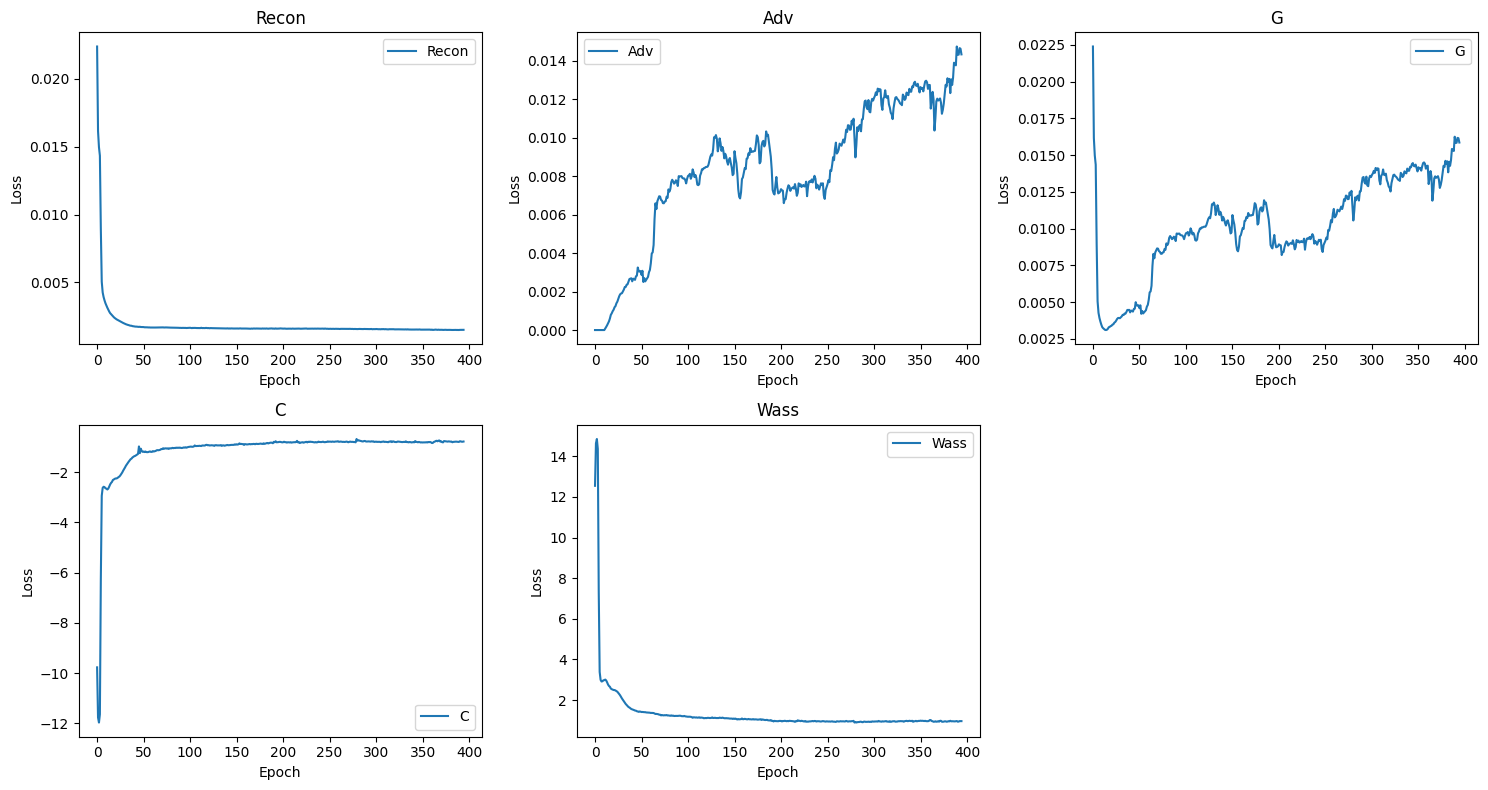

In [23]:
tcn.plot_losses()

In [35]:
# test training results
from osu.rulesets.mods import Mods
import osu.rulesets.beatmap as bm
import osu.dataset as dataset
import torch

test_name = 'rubiks'
test_mods = Mods.HARD_ROCK 
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map_path)
test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
# no chunking for lstm based
data = np.reshape(data.values, (-1, data.shape[0], len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)

Turning Rubik's Cube into time series data: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.94it/s]


In [36]:
replay_data = model.generate(data)
print(replay_data.shape)
    
replay_data = np.concatenate(replay_data)
replay_data = np.pad(replay_data, ((0, 0), (0, 2)), mode='constant', constant_values=0)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
print(f"Generated replay data shape: {replay_data.shape}")
replay_data


Generated data saved to rubiks_tcn_wgan.npy.npy


AttributeError: 'NoneType' object has no attribute 'shape'

In [29]:
import osu.preview.preview as preview

preview.preview_replay_raw(replay_data[:, :4], test_map_path, test_mods, test_song)